# ScmRun
This notebooks describes the new functionality associated with the `ScmRun` class compared to `ScmDataFrame`. This class is tipped to be eventually replace the `ScmDataFrame` as it provides better performance when dealing with a large number of time-series.

These performance improvements are due to a change in how the time-series are stored and accessed. Our usage patterns for `ScmDataFrame` often involved many filtering or groupby operations. `ScmDataFrame` stored all of the time series data in a single pandas dataframe and all the metadata in another separate dataframe. Operations on the data required complicated joins between the two tables to ensure that they both remained in sync. This resulted in complicated code and limiations around what metadata was stored.

`ScmRun` is a container for `TimeSeries` objects. Filtering by metadata reduces to the set of `TimeSeries` objects with the matching metadata. No more costly recreating of the pandas dataframes on every filter and each `TimeSeries` can have unique metadata.

In [1]:
# NBVAL_IGNORE_OUTPUT
from scmdata import ScmDataFrame, df_append
from scmdata.run import ScmRun, df_append as run_append
import numpy as np

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
def new_timeseries(
    n=100,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": "World",
            "unit": "K",
            "c": list(range(1, count + 1)),
            **kwargs,
        },
        index=index,
    )

In [3]:
run = new_timeseries(count=3)
run

<scmdata.ScmRun (timeseries: 3, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	     model scenario             variable region unit  c
	0  example   ssp119  Surface Temperature  World    K  1
	1  example   ssp119  Surface Temperature  World    K  2
	2  example   ssp119  Surface Temperature  World    K  3

In [4]:
# NBVAL_IGNORE_OUTPUT
df = new_timeseries(cls=ScmDataFrame)
df

### Appending performance

In [5]:
# NBVAL_SKIP
dfs = [new_timeseries(cls=ScmDataFrame, run_id=i) for i in range(1000)]

%timeit df_append(dfs)

7.33 s ± 188 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# NBVAL_SKIP
runs = [new_timeseries(run_id=i) for i in range(1000)]

%timeit run_append(runs)

14.4 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Filtering Performance

In [7]:
# NBVAL_SKIP
# results are Scmdataframe and then scmrun for each data point
for count in [1, 10, 100]:
    for n_runs in [1, 10, 100]:
        print("Count {} N_runs {}".format(count, n_runs))
        
        dfs = df_append([new_timeseries(cls=ScmDataFrame, run_id=i, count=count) for i in range(n_runs)])
        runs = run_append([new_timeseries(run_id=i, count=count) for i in range(n_runs)])

        %timeit dfs.filter(c=1)
        %timeit runs.filter(c=1)
        print()

Count 1 N_runs 1
5.13 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
752 µs ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Count 1 N_runs 10
5 ms ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
783 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Count 1 N_runs 100
5.91 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.16 ms ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Count 10 N_runs 1
5.18 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
779 µs ± 19.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Count 10 N_runs 10
5.84 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.16 ms ± 36.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Count 10 N_runs 100
10.1 ms ± 377 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.95 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Count 100 N_runs 1
5.63 ms

## Other Features

The filtered run is now a "view" to the data. Changing the metadata or values of the filtered run will change the original.

If this functionality is not wanted, ensure that a copy of the run is created with `.copy()`. Any subsequent changes to the timeseries data or metadata won't be reflected in the parent object.

In [8]:
# NBVAL_IGNORE_OUTPUT
runs = new_timeseries(count=3)
runs.filter(c=2)["extra"] = "test"
runs

<scmdata.ScmRun (timeseries: 3, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	         model scenario             variable region unit  c extra
	13324  example   ssp119  Surface Temperature  World    K  1   NaN
	13325  example   ssp119  Surface Temperature  World    K  2  test
	13326  example   ssp119  Surface Temperature  World    K  3   NaN

In [9]:
# NBVAL_IGNORE_OUTPUT
runs.meta

,model,scenario,variable,region,unit,c,extra
13324,example,ssp119,Surface Temperature,World,K,1,NaN
13325,example,ssp119,Surface Temperature,World,K,2,test
13326,example,ssp119,Surface Temperature,World,K,3,NaN


`ScmRun` also has a groupby command to make it easy to iterate over groups.

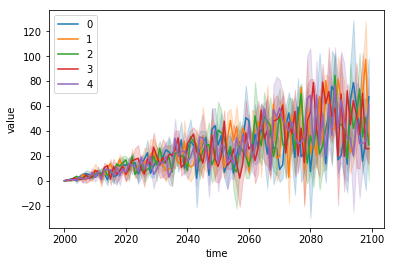

In [10]:
# NBVAL_IGNORE_OUTPUT
runs = run_append([new_timeseries(run_id=i, count=3) for i in range(5)])
for group in runs.groupby("run_id"):
    group.lineplot(hue=None, label=group.get_unique_meta("run_id", True))

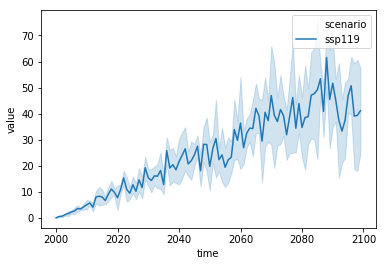

In [11]:
# NBVAL_IGNORE_OUTPUT
# Aggregate by run_id
runs.groupby("run_id").mean(axis=0).lineplot()

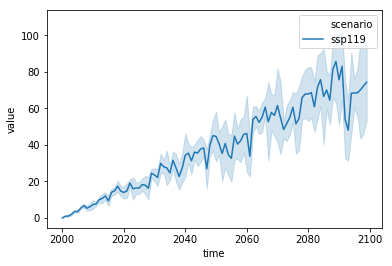

In [12]:
# NBVAL_IGNORE_OUTPUT
runs.groupby("run_id").max(axis=0).lineplot()